# Image Retrieval Project with Embedding

## 1. Load data

In [1]:
!gdown 1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF
!unzip data.zip

Downloading...
From (original): https://drive.google.com/uc?id=1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF
From (redirected): https://drive.google.com/uc?id=1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF&confirm=t&uuid=b0ef0403-6e2a-4a4b-9655-6d77af005645
To: /content/data.zip
100% 76.1M/76.1M [00:00<00:00, 122MB/s]
Archive:  data.zip
   creating: data/
   creating: data/.ipynb_checkpoints/
   creating: data/test/
   creating: data/test/American_egret/
  inflating: data/test/American_egret/n02009912_2473.JPEG  
   creating: data/test/Doberman/
  inflating: data/test/Doberman/n02107142_52285.JPEG  
   creating: data/test/Rhodesian_ridgeback/
  inflating: data/test/Rhodesian_ridgeback/n02087394_18723.JPEG  
   creating: data/test/African_crocodile/
  inflating: data/test/African_crocodile/n01697457_18534.JPEG  
   creating: data/test/Lakeland_terrier/
  inflating: data/test/Lakeland_terrier/n02095570_4644.JPEG  
   creating: data/test/ambulance/
  inflating: data/test/ambulance/n02701002_2311.JPEG  
   creatin

## 2. Import libraries

In [2]:
!pip install chromadb
!pip install open-clip-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 282.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.3/584.3 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 65.3 MB/s eta 0:0

In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

## 3. Read data

In [4]:
ROOT = "data"
CLASS_NAME = sorted(list(os.listdir(f"{ROOT}/train")))

In [5]:
def read_image_from_path(path, size):
    im = Image.open(path).convert("RGB").resize(size)
    return np.array(im)

def folder_to_images(folder, size):
    list_dir = [folder + "/" + name for name in os.listdir(folder)]
    images_np = np.zeros(shape=(len(list_dir), *size, 3))
    images_path = []
    for i, path in enumerate(list_dir):
        images_np[i] = read_image_from_path(path, size)
        images_path.append(path)
    images_path = np.array(images_path)
    return images_np, images_path

## 4. Measure functions

In [6]:
def absolute_difference(query, data, axis):
    return np.sum(np.abs(data - query), axis = axis)

def mean_square_difference(query, data, axis):
    return np.mean((data - query)**2, axis=axis)

def cosine_similarity(query, data, axis):
    query_norm = np.sqrt(np.sum(query**2))
    data_norm = np.sqrt(np.sum(data**2, axis=axis))
    return np.sum(data * query, axis=axis) / (query_norm*data_norm + np.finfo(float).eps)

def correlation_coefficient(query, data, axis):
    query_mean = query - np.mean(query)
    data_mean = data - np.mean(data, axis=axis, keepdims=True)
    query_norm = np.sqrt(np.sum(query_mean**2))
    data_norm = np.sqrt(np.sum(data_mean**2, axis=axis))
    return np.sum(data_mean * query_mean, axis=axis) / (query_norm*data_norm + np.finfo(float).eps)

def measure_function(query, data, measure_type):
    axis_batch_size = tuple(range(1, len(data.shape)))
    result = None
    if measure_type == "l1":
        result = absolute_difference(query, data, axis_batch_size)
    elif measure_type == "l2":
        result = mean_square_difference(query, data, axis_batch_size)
    elif measure_type == "cosine":
        result = cosine_similarity(query, data, axis_batch_size)
    elif measure_type == "coeff":
        result = correlation_coefficient(query, data, axis_batch_size)
    return result

## 5. Get image scores

In [7]:
embedding_function = OpenCLIPEmbeddingFunction()

def get_single_image_embedding(image):
    embedding = embedding_function._encode_image(image=image)
    return np.array(embedding)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [8]:
def get_embedding_image_score(root_img_path, query_path, size, measure_type, reverse):
    query = read_image_from_path(query_path, size)
    query_embedding = get_single_image_embedding(query)
    ls_path_score = []
    for folder in os.listdir(root_img_path):
        if folder in CLASS_NAME:
            path = root_img_path + folder
            images_np, images_path = folder_to_images(path, size)
            embedding_list = []
            for idx_img in range(images_np.shape[0]):
                embedding = get_single_image_embedding(images_np[idx_img].astype(np.uint8))
                embedding_list.append(embedding)
            rates = measure_function(query_embedding, np.stack(embedding_list), measure_type)
            ls_path_score.extend(list(zip(images_path, rates)))
    ls_path_score = sorted(ls_path_score, key=lambda x : x[1], reverse=reverse)[:5]
    return query, ls_path_score

## 6. Show results

In [9]:
def plot_results(querquery_pathy, ls_path_score):
    fig = plt.figure(figsize=(12, 5))
    fig.add_subplot(2, 3, 1)
    plt.imshow(read_image_from_path(querquery_pathy, size=(448,448)))
    plt.title(f"Query Image: {querquery_pathy.split('/')[2]}", fontsize=16)
    plt.axis("off")
    for i, path in enumerate(ls_path_score, 2):
        fig.add_subplot(2, 3, i)
        plt.imshow(read_image_from_path(path[0], size=(448,448)))
        plt.title(f"Top {i-1}: {path[0].split('/')[2]}", fontsize=16)
        plt.axis("off")
    plt.show()

### Simple image

In [10]:
root_img_path = f"{ROOT}/train/"
size = (448, 448)
query_path_1 = f"{ROOT}/test/Orange_easy/0_100.jpg"

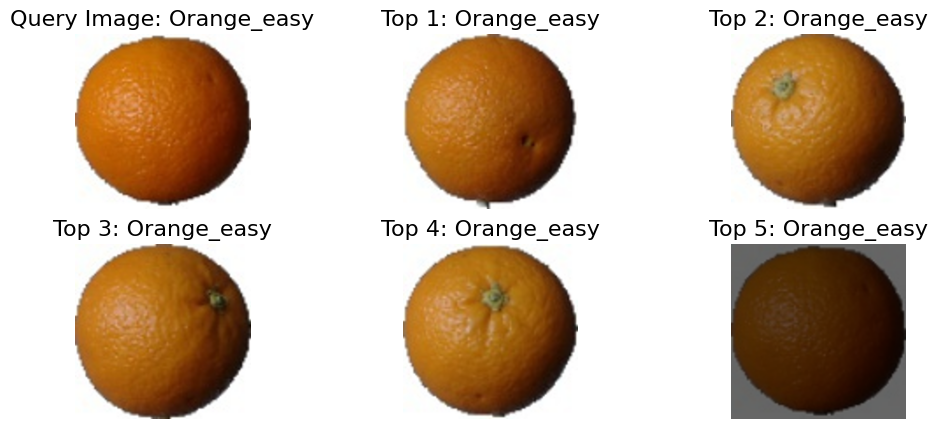

In [11]:
# L1
query, ls_path_score = get_embedding_image_score(root_img_path, query_path_1, size, "l1", reverse=False)
plot_results(query_path_1, ls_path_score)

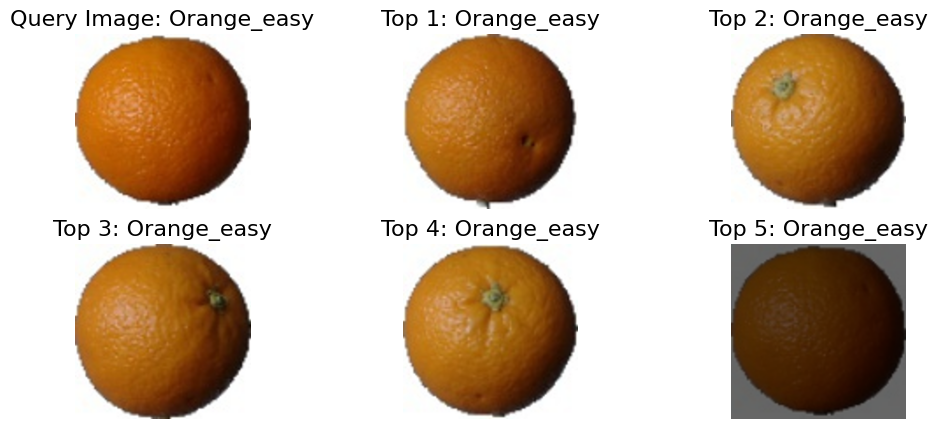

In [12]:
# L2
query, ls_path_score = get_embedding_image_score(root_img_path, query_path_1, size, "l2", reverse=False)
plot_results(query_path_1, ls_path_score)

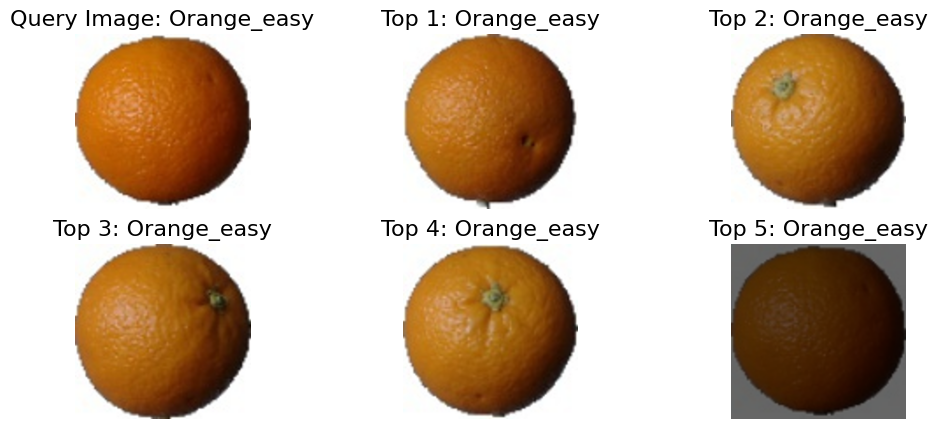

In [13]:
# Cosine similarity
query, ls_path_score = get_embedding_image_score(root_img_path, query_path_1, size, "cosine", reverse=True)
plot_results(query_path_1, ls_path_score)

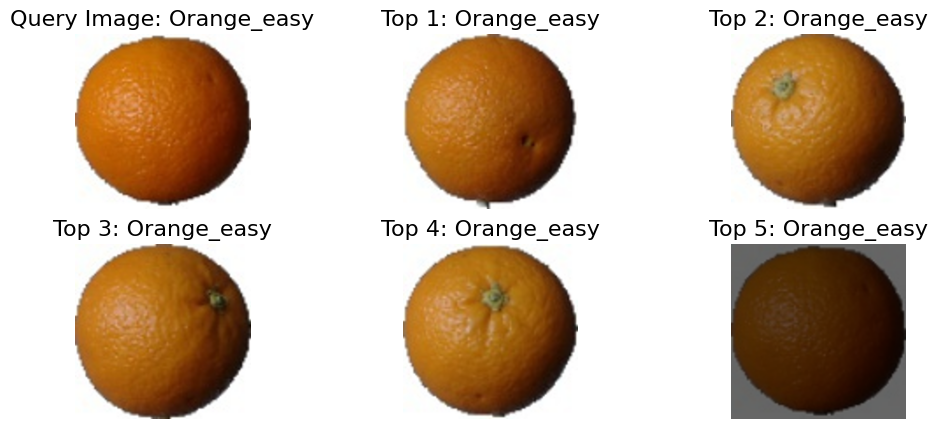

In [14]:
# Correlation coefficient
query, ls_path_score = get_embedding_image_score(root_img_path, query_path_1, size, "coeff", reverse=True)
plot_results(query_path_1, ls_path_score)

### Hard image

In [15]:
query_path_2 = f"{ROOT}/test/African_crocodile/n01697457_18534.JPEG"

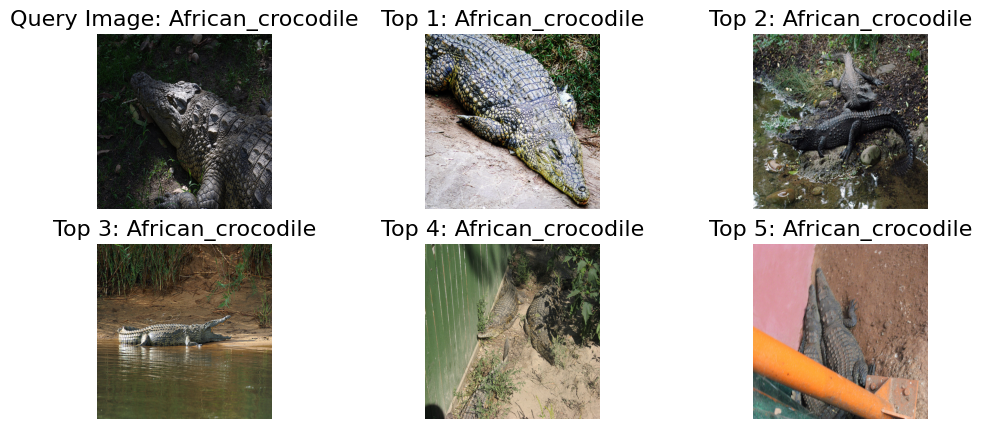

In [17]:
# L1
query, ls_path_score = get_embedding_image_score(root_img_path, query_path_2, size, "l1", reverse=False)
plot_results(query_path_2, ls_path_score)

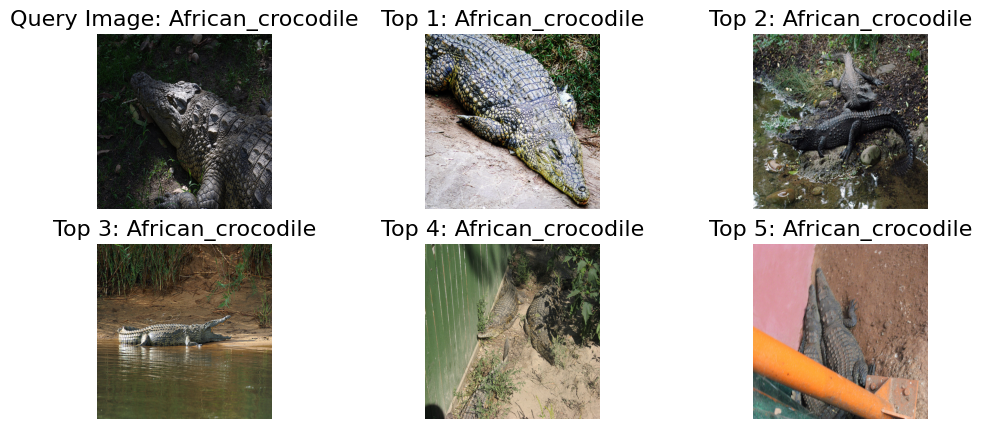

In [18]:
# L2
query, ls_path_score = get_embedding_image_score(root_img_path, query_path_2, size, "l2", reverse=False)
plot_results(query_path_2, ls_path_score)

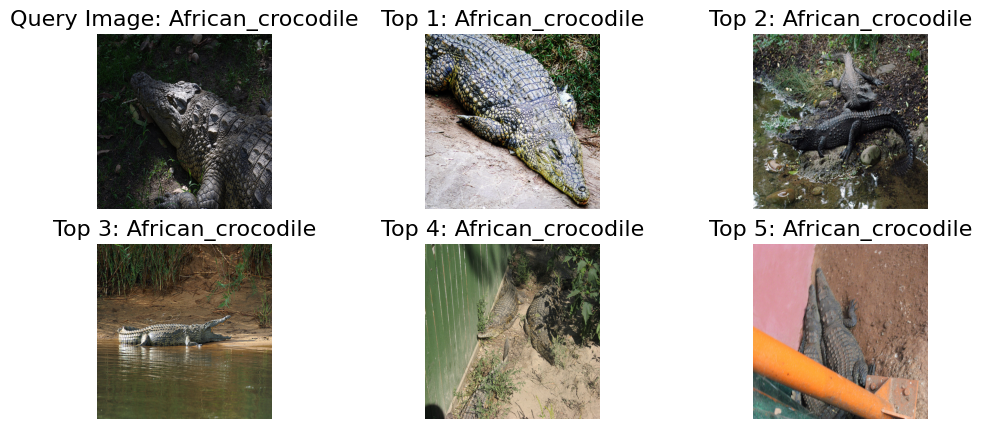

In [19]:
# Cosine similarity
query, ls_path_score = get_embedding_image_score(root_img_path, query_path_2, size, "cosine", reverse=True)
plot_results(query_path_2, ls_path_score)

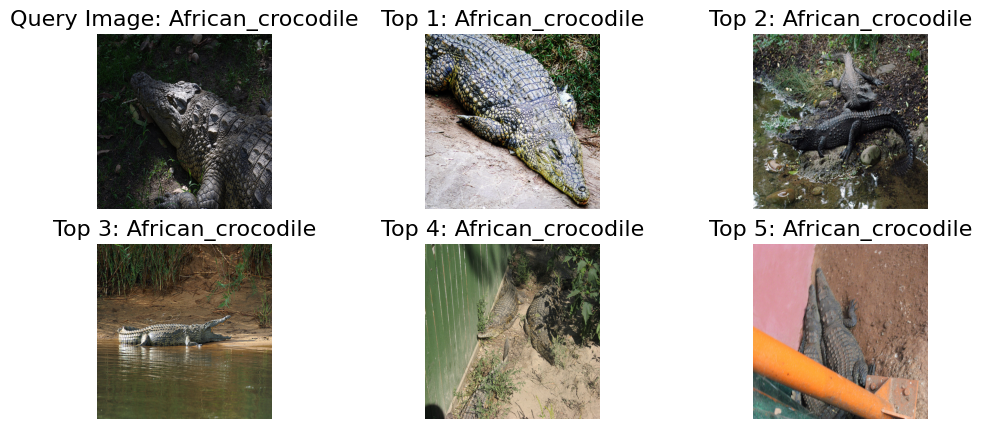

In [20]:
# Correlation coefficient
query, ls_path_score = get_embedding_image_score(root_img_path, query_path_2, size, "coeff", reverse=True)
plot_results(query_path_2, ls_path_score)